# Farm Receipts from Expenses Notebook

This notebook replicates the `farm_receipts_from_expenses.py` script with:
- Data parsing
- Model training & 5-fold CV
- Built-in & permutation feature importances
- Out-of-fold residual analysis


In [3]:
%pip install pandas numpy scikit-learn joblib openpyxl matplotlib seaborn notebook


  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for notebook from https://files.pythonhosted.org/packages/1e/16/d3c36a0b1f6dfcf218add8eaf803bf0473ff50681ac4d51acb7ba02bce34/notebook-7.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for jupyter-server<3,>=2.4.0 from https://files.pythonhosted.org/packages/e2/a2/89eeaf0bb954a123a909859fa507fa86f96eb61b62dc30667b60dbd5fdaf/jupyter_server-2.15.0-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-server<3,>=2.27.1 from https://files.pythonhosted.org/packages/54/09/2032e7d15c544a0e3cd831c51d77a8ca57f7555b2e1b2922142eddb02a84/jupyterlab_server-2.27.3-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab<4.5,>=4.4.0 from https://files.pythonhosted.org/packages/f6/ae/fbb93f4990b7648849b19112d8b3e74


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.inspection import permutation_importance

# Helper functions
def _is_year(v):
    if isinstance(v, (int, float)) and not pd.isna(v):
        return 1900 <= int(v) <= 2100
    if isinstance(v, str):
        return bool(re.match(r"\d{4}", v))
    return False

def _find_year_row(df):
    for r in range(min(15, df.shape[0])):
        if sum(_is_year(x) for x in df.iloc[r, 1:15]) >= 3:
            return r
    raise ValueError("Year header row not found")

def _parse_years(row):
    yrs = []
    for v in row:
        if _is_year(v):
            yrs.append(int(re.match(r"(\d{4})", str(v)).group(1)) if isinstance(v, str) else int(v))
    return yrs

def parse_bea_sheet(df):
    yr_idx = _find_year_row(df)
    years = _parse_years(df.iloc[yr_idx, 1:].values)
    cols = [j for j in range(1, df.shape[1]) if _is_year(df.iloc[yr_idx, j])]
    start = yr_idx + 2
    data = {}
    for i in range(start, df.shape[0]):
        cat = df.iloc[i, 0]
        if isinstance(cat, str) and cat.strip() and not cat.lower().startswith("footnote"):
            vals = []
            for j in cols[:len(years)]:
                v = df.iloc[i, j]
                if isinstance(v, (int, float)):
                    vals.append(float(v))
                elif isinstance(v, str):
                    s = v.replace(",", "").replace("$", "").replace(" ", "").replace(" ", "")
                    try:
                        vals.append(float(s))
                    except ValueError:
                        vals.append(np.nan)
                else:
                    vals.append(np.nan)
            if not all(pd.isna(vals)):
                data[cat.strip().lower()] = vals
    return pd.DataFrame(data, index=years)


In [5]:
# Paths
INC_PATH = "IncomeDataLarge_raw.xlsx"
EXP_PATH = "PE_State_US_raw.xlsx"

# Load data
inc_df = parse_bea_sheet(pd.read_excel(INC_PATH, sheet_name="United States", header=None)).sort_index()
exp_df = parse_bea_sheet(pd.read_excel(EXP_PATH, sheet_name="United States", header=None)).sort_index()

# Build dataset
expense_cols = [
    "seed",
    "fertilizer, lime, and soil conditioner",
    "fuel and oils",
    "electricity",
    "hired labor",
    "pesticide",
    "machine hire and custom work",
    "marketing, storage, and transportation",
    "nonreal estate interest",
]
expense_cols = [c for c in expense_cols if c in exp_df.columns]
data = pd.concat([inc_df["all commodity receipts"], exp_df[expense_cols]], axis=1).dropna()
y = data["all commodity receipts"]
X = data[expense_cols]


In [6]:
# 5-fold CV
rf = RandomForestRegressor(n_estimators=500, random_state=0)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
cv_r2 = cross_val_score(rf, X, y, cv=cv, scoring="r2")
print("5-fold CV R² scores:", np.round(cv_r2,5))
print("Mean CV R²:", cv_r2.mean())

# Fit full model
rf.fit(X, y)


5-fold CV R² scores: [0.9868  0.99552 0.99016 0.98186 0.97024]
Mean CV R²: 0.9849168846162062


RandomForestRegressor(n_estimators=500, random_state=0)

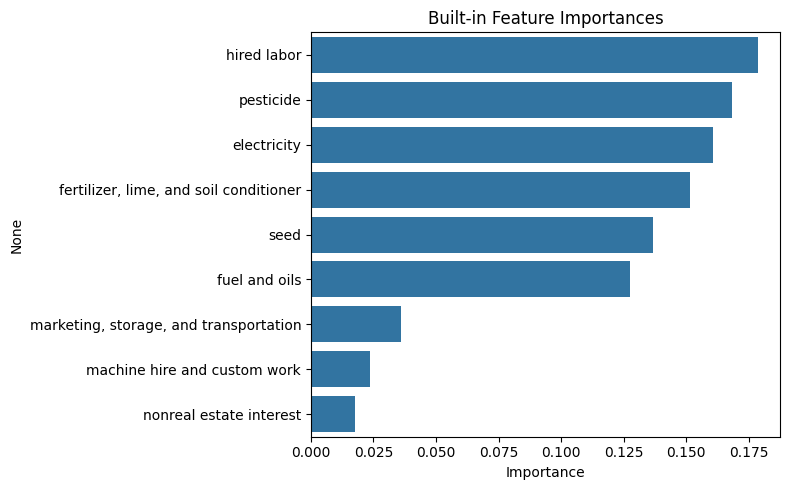

In [7]:
# Built-in feature importances
importances = pd.Series(rf.feature_importances_, index=expense_cols).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Built-in Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


                                        Mean Importance       Std
pesticide                                      0.058677  0.007665
electricity                                    0.052733  0.006819
hired labor                                    0.051645  0.007072
fertilizer, lime, and soil conditioner         0.048736  0.007514
seed                                           0.042948  0.005557
fuel and oils                                  0.027043  0.003595
marketing, storage, and transportation         0.006659  0.000804
machine hire and custom work                   0.005657  0.000671
nonreal estate interest                        0.003524  0.000510


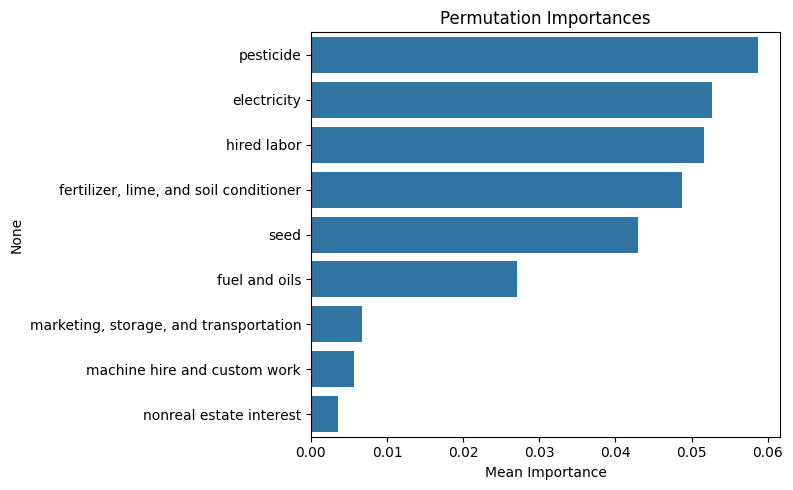

In [8]:
# Permutation importances
perm = permutation_importance(rf, X, y, n_repeats=30, random_state=0)
perm_df = pd.DataFrame({
    'Mean Importance': perm.importances_mean,
    'Std': perm.importances_std
}, index=expense_cols).sort_values('Mean Importance', ascending=False)
print(perm_df)
plt.figure(figsize=(8,5))
sns.barplot(x='Mean Importance', y=perm_df.index, data=perm_df)
plt.title('Permutation Importances')
plt.tight_layout()
plt.show()


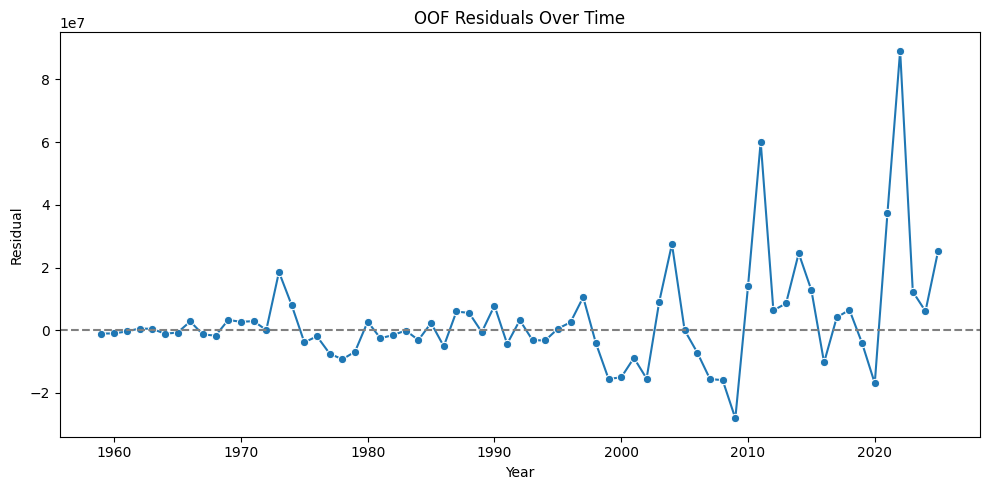

In [9]:
# Out-of-fold residuals
oof_pred = cross_val_predict(rf, X, y, cv=cv)
res_oof = y - oof_pred
res_df = pd.DataFrame({'Year': data.index, 'Residual': res_oof})

plt.figure(figsize=(10,5))
sns.lineplot(x='Year', y='Residual', data=res_df, marker='o')
plt.axhline(0, linestyle='--', color='gray')
plt.title('OOF Residuals Over Time')
plt.tight_layout()
plt.show()


## End of Analysis